# Triple Star Search
### First notebook - identify possible interactions
This notebook sums up all of the steps I took to find the indices of any stars that may have passed within one arcsecond of one another with trajectories traced by their proper motions over a timescale of one million years.

The overall procedure is:
* Open .fits file of Gaia data from Orion (this could be made more efficient).
* Use HR diagram cuts to filter, isolate young stars.
* Project all applicable stars back by timesteps of 100 years, retaining the indices when stars pass withiin one arcsecond of one another.
* Write indices and timesteps of retained data to a .npz file, which is picked up in following work.

The process of identifying matched pairs for the large sample size and number of timesteps we use is time-intensive, and since the .npz file this notebook writes is included, there should be no reason to run this file.

In [2]:
from astropy.io import fits
from astropy.table import Table, QTable
import astropy.table as table
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import sqrt, log10

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
#Open the appropriate fits file, extract relevant data, close file
hdul = fits.open('c:\\users\\sahal\\2018TrinaryWork\\gaiadr2_OrionTables.fits')
pmra_all = hdul[1].data['pmra'] / 3600000 #pmra is in mas/yr - converts to deg/yr
pmdec_all = hdul[1].data['pmdec'] / 3600000 #pmdec is in mas/yr - converts to deg/yr
radial_velocity_all = hdul[1].data['radial_velocity'] #radial velocity is in mas/yr? or parsec/yr?
source_id_all = hdul[1].data['source_id']
ra_all = hdul[1].data['ra'] #ra in deg
dec_all = hdul[1].data['dec'] #dec in deg
parallax_all = hdul[1].data['parallax'] #parallax in mas

G_all = hdul[1].data['phot_g_mean_mag'] #magnitudes in G filter
Gb_all = hdul[1].data['phot_bp_mean_mag']#magnitudes in Gbp filter
Gr_all = hdul[1].data['phot_rp_mean_mag']#magnitudes in Brp filter

bp_rp_all = hdul[1].data['bp_rp']#color difference b-r
#This is the same as subtracting Gb - Gr

ra_err_all = hdul[1].data['ra_error']
dec_err_all = hdul[1].data['dec_error']
pmra_err_all = hdul[1].data['pmra_error']
pmdec_err_all = hdul[1].data['pmdec_error']

hdul.close()

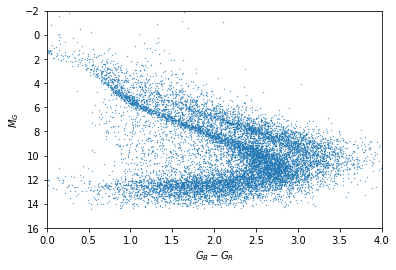

In [4]:
#Absolute magnitude in terms of G and p
Mg_all = [G + 5 - 5*(log10(1000/p)) for G, p in zip(G_all, parallax_all)]
#p is in mas so we divide the listed 1000 by 10

plt.plot(bp_rp_all, Mg_all, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(16,-2)
plt.xlabel("$G_B - G_R$")
plt.ylabel("$M_G$")
plt.show()

In [5]:
#Get the indices ii of all values for stars that satisfy appropriate photometric conditions
ii = []

for i in range(len(source_id_all)):
    if( (Mg_all[i]<2.46*(bp_rp_all[i])+2.76 and .3<(bp_rp_all[i])<1.8)
       or (Mg_all[i]<2.8*(bp_rp_all[i])+2.16 and 1.8<(bp_rp_all[i]))):
       #or (Mg_all[i]>2.14*(bp_rp_all[i])-.57 and .5<(bp_rp_all[i])<1.2)
       #or (Mg_all[i]>1.11*(bp_rp_all[i])+.66 and 1.2<(bp_rp_all[i])<3)):
        ii.append(i)
        
print(len(ii))

4022


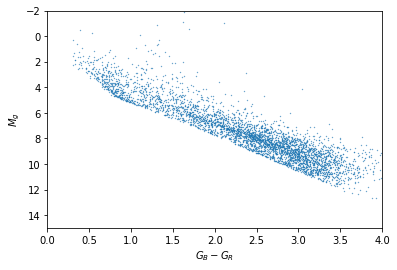

In [6]:
#Redefine our data as all stars that fit photometric parameters of young stars
pmra = pmra_all[ii]
pmdec = pmdec_all[ii]
radial_velocity = radial_velocity_all[ii]
source_id = source_id_all[ii]
ra = ra_all[ii]
dec = dec_all[ii]
parallax = parallax_all[ii]

G = G_all[ii]
Gb = Gb_all[ii]
Gr = Gr_all[ii]

bp_rp = bp_rp_all[ii]

ra_err = ra_err_all[ii]
dec_err = dec_err_all[ii]
pmra_err = pmra_err_all[ii]
pmdec_err = pmdec_err_all[ii]

#############################

Mg = [G + 5 - 5 * log10(1000/p) for G, p in zip(G, parallax)]

plt.plot(bp_rp, Mg, '.',markersize = .6)
plt.xlim(0,4)
plt.ylim(15,-2)
plt.xlabel("$G_B - G_R$")
plt.ylabel("$M_g$")
plt.show()

In [7]:
def toffset(pmra, pmdec, dt):
    return (pmra * dt, pmdec * dt)

def dist(ra, dec):
    return np.array([np.sqrt( (ra[i]-ra)**2 +  (dec[i]-dec)**2 ) for i in range(len(ra))])

arcsec = 1 / 3600
def updated(ra_in, dec_in, pmra_in, pmdec_in, tstep):
    pmraProj, pmdecProj = toffset(pmra_in, pmdec_in, tstep)
    ra_t = ra_in + pmraProj
    dec_t = dec_in + pmdecProj
    
    alldists = dist(ra_t,dec_t)
    
    successfulMatch = np.where((alldists < arcsec) & (alldists != 0.))
    
    return [tstep,successfulMatch[0]]    


In [26]:
allMatches = []
for t in range(-1000000,100,100):
    val = updated(ra, dec, pmra, pmdec, t)
    #print(vals)
    print(val[0], val[1])
    if val[1].size > 0:
        allMatches.append(val)

#After several attempts at trying to save data to files via astropy tables, I've concluded 
#the best way to go is with numpy's .npz

fnam = 'timecoords.npz'

a = np.array([allMatches[i][0] for i in range(len(allMatches))])
b = np.array([allMatches[i][1] for i in range(len(allMatches))])

np.savez(fnam, time = a, ind = b)

-1000000 []
-999900 []
-999800 []
-999700 []
-999600 []
-999500 []
-999400 []
-999300 []
-999200 []
-999100 []
-999000 []
-998900 []
-998800 []
-998700 []
-998600 []
-998500 []
-998400 []
-998300 []
-998200 []
-998100 []
-998000 []
-997900 []
-997800 []
-997700 []
-997600 []
-997500 []
-997400 []
-997300 []
-997200 []
-997100 []
-997000 []
-996900 []
-996800 []
-996700 []
-996600 []
-996500 []
-996400 []
-996300 []
-996200 []
-996100 []
-996000 []
-995900 []
-995800 []
-995700 []
-995600 []
-995500 []
-995400 []
-995300 []
-995200 []
-995100 []
-995000 []
-994900 []
-994800 []
-994700 []
-994600 []
-994500 []
-994400 []
-994300 []
-994200 []
-994100 []
-994000 []
-993900 []
-993800 []
-993700 []
-993600 []
-993500 []
-993400 []
-993300 []
-993200 []
-993100 []
-993000 []
-992900 []
-992800 []
-992700 []
-992600 []
-992500 []
-992400 []
-992300 []
-992200 []
-992100 []
-992000 []
-991900 []
-991800 []
-991700 []
-991600 []
-991500 []
-991400 []
-991300 []
-991200 []
-991100 []
-991000 [

-932700 []
-932600 []
-932500 []
-932400 []
-932300 []
-932200 []
-932100 []
-932000 []
-931900 []
-931800 []
-931700 []
-931600 []
-931500 []
-931400 [3087 3273]
-931300 [3087 3273]
-931200 [3087 3273]
-931100 [3087 3273]
-931000 [ 662 1653 3087 3273]
-930900 [ 662 1653 3087 3273]
-930800 [ 662 1653 3087 3273]
-930700 [ 662 1653 3087 3273]
-930600 [3087 3273]
-930500 [3087 3273]
-930400 [3087 3273]
-930300 [3087 3273]
-930200 [3087 3273]
-930100 [3087 3273]
-930000 [3087 3273]
-929900 []
-929800 []
-929700 []
-929600 []
-929500 []
-929400 []
-929300 []
-929200 []
-929100 []
-929000 []
-928900 []
-928800 []
-928700 []
-928600 []
-928500 []
-928400 []
-928300 []
-928200 []
-928100 []
-928000 []
-927900 []
-927800 []
-927700 []
-927600 []
-927500 []
-927400 []
-927300 []
-927200 []
-927100 []
-927000 []
-926900 []
-926800 []
-926700 []
-926600 []
-926500 []
-926400 []
-926300 []
-926200 []
-926100 []
-926000 []
-925900 []
-925800 []
-925700 []
-925600 []
-925500 []
-925400 []
-925300 []


-868400 []
-868300 []
-868200 []
-868100 []
-868000 []
-867900 []
-867800 []
-867700 []
-867600 []
-867500 []
-867400 []
-867300 []
-867200 []
-867100 []
-867000 []
-866900 []
-866800 []
-866700 []
-866600 []
-866500 []
-866400 []
-866300 []
-866200 []
-866100 []
-866000 []
-865900 []
-865800 []
-865700 []
-865600 []
-865500 []
-865400 []
-865300 []
-865200 []
-865100 []
-865000 []
-864900 []
-864800 []
-864700 []
-864600 []
-864500 []
-864400 []
-864300 []
-864200 []
-864100 []
-864000 []
-863900 []
-863800 []
-863700 []
-863600 []
-863500 []
-863400 []
-863300 []
-863200 []
-863100 []
-863000 []
-862900 []
-862800 []
-862700 []
-862600 []
-862500 []
-862400 []
-862300 []
-862200 []
-862100 []
-862000 [ 221 1646]
-861900 [ 221 1646]
-861800 []
-861700 []
-861600 []
-861500 []
-861400 []
-861300 []
-861200 []
-861100 []
-861000 []
-860900 []
-860800 []
-860700 []
-860600 []
-860500 []
-860400 []
-860300 []
-860200 []
-860100 []
-860000 []
-859900 []
-859800 []
-859700 []
-859600 []
-85

-805500 [ 993 1784]
-805400 [ 993 1784]
-805300 [ 993 1784]
-805200 []
-805100 []
-805000 []
-804900 []
-804800 []
-804700 []
-804600 []
-804500 []
-804400 []
-804300 []
-804200 []
-804100 []
-804000 []
-803900 []
-803800 []
-803700 []
-803600 []
-803500 []
-803400 []
-803300 []
-803200 []
-803100 []
-803000 []
-802900 []
-802800 []
-802700 []
-802600 []
-802500 []
-802400 []
-802300 []
-802200 []
-802100 []
-802000 []
-801900 []
-801800 []
-801700 []
-801600 []
-801500 []
-801400 []
-801300 []
-801200 []
-801100 []
-801000 []
-800900 []
-800800 []
-800700 []
-800600 []
-800500 []
-800400 []
-800300 []
-800200 []
-800100 []
-800000 []
-799900 []
-799800 []
-799700 []
-799600 []
-799500 []
-799400 []
-799300 []
-799200 []
-799100 []
-799000 []
-798900 []
-798800 []
-798700 []
-798600 []
-798500 []
-798400 []
-798300 []
-798200 []
-798100 []
-798000 []
-797900 []
-797800 []
-797700 []
-797600 []
-797500 []
-797400 []
-797300 []
-797200 []
-797100 []
-797000 []
-796900 []
-796800 []
-7967

-739700 []
-739600 []
-739500 []
-739400 []
-739300 [647 708]
-739200 [647 708]
-739100 [647 708]
-739000 [647 708]
-738900 [647 708]
-738800 [647 708]
-738700 [647 708]
-738600 [647 708]
-738500 [647 708]
-738400 [647 708]
-738300 [647 708]
-738200 [647 708]
-738100 [647 708]
-738000 [647 708]
-737900 [647 708]
-737800 [647 708]
-737700 [647 708]
-737600 [647 708]
-737500 [647 708]
-737400 [647 708]
-737300 [647 708]
-737200 [647 708]
-737100 [647 708]
-737000 [647 708]
-736900 [647 708]
-736800 [647 708]
-736700 [647 708]
-736600 [647 708]
-736500 [647 708]
-736400 [647 708]
-736300 []
-736200 []
-736100 []
-736000 []
-735900 []
-735800 []
-735700 []
-735600 []
-735500 []
-735400 []
-735300 []
-735200 []
-735100 []
-735000 []
-734900 []
-734800 []
-734700 []
-734600 []
-734500 []
-734400 []
-734300 []
-734200 []
-734100 []
-734000 []
-733900 []
-733800 []
-733700 []
-733600 []
-733500 []
-733400 []
-733300 []
-733200 []
-733100 []
-733000 []
-732900 []
-732800 []
-732700 []
-732600 [

-676700 []
-676600 []
-676500 []
-676400 []
-676300 []
-676200 []
-676100 []
-676000 [2596 2725]
-675900 [2596 2725]
-675800 []
-675700 [2870 3023]
-675600 [2870 3023]
-675500 [2870 3023]
-675400 [2870 3023]
-675300 [1488 1774 2870 3023]
-675200 [1488 1774 2870 3023]
-675100 [1488 1774 2870 3023]
-675000 [1488 1774 2870 3023]
-674900 [2870 3023]
-674800 [2870 3023]
-674700 [2870 3023]
-674600 [2870 3023]
-674500 [2870 3023]
-674400 [2870 3023]
-674300 [2870 3023]
-674200 [2870 3023]
-674100 []
-674000 []
-673900 []
-673800 []
-673700 []
-673600 []
-673500 []
-673400 []
-673300 []
-673200 []
-673100 [1881 3933]
-673000 []
-672900 []
-672800 []
-672700 []
-672600 []
-672500 []
-672400 []
-672300 []
-672200 []
-672100 []
-672000 []
-671900 []
-671800 []
-671700 []
-671600 []
-671500 []
-671400 []
-671300 []
-671200 []
-671100 []
-671000 []
-670900 [1468 2427]
-670800 [1468 2427]
-670700 [1468 2427]
-670600 [1468 2427]
-670500 [1468 2427]
-670400 [1468 2427]
-670300 [1468 2427]
-670200 []


-611500 [ 837 1051 1140 1263]
-611400 [ 837 1051 1140 1263]
-611300 [ 837 1051 1140 1263]
-611200 [ 837 1051 1140 1263]
-611100 [1140 1263]
-611000 []
-610900 []
-610800 []
-610700 []
-610600 []
-610500 []
-610400 []
-610300 []
-610200 []
-610100 []
-610000 []
-609900 []
-609800 []
-609700 []
-609600 []
-609500 []
-609400 []
-609300 []
-609200 []
-609100 []
-609000 []
-608900 []
-608800 []
-608700 []
-608600 []
-608500 []
-608400 []
-608300 []
-608200 []
-608100 []
-608000 []
-607900 []
-607800 []
-607700 []
-607600 [374 649]
-607500 [374 649]
-607400 [374 649]
-607300 [374 649]
-607200 [374 649]
-607100 [374 649]
-607000 [374 649]
-606900 [374 649]
-606800 [374 649]
-606700 [374 649]
-606600 [ 374  649 1017 1237]
-606500 [ 374  649 1017 1237]
-606400 [ 374  649 1017 1237]
-606300 [ 374  649 1017 1237]
-606200 [ 374  649 1017 1237]
-606100 [ 202  364  374  649 1017 1237]
-606000 [ 202  364  374  649 1017 1237]
-605900 [ 202  364  374  649 1017 1237]
-605800 [ 202  364  374  649 1017 12

-549200 []
-549100 []
-549000 []
-548900 []
-548800 []
-548700 []
-548600 []
-548500 []
-548400 []
-548300 []
-548200 [631 700]
-548100 [631 700]
-548000 [631 700]
-547900 [631 700]
-547800 [631 700]
-547700 [631 700]
-547600 [631 700]
-547500 [631 700]
-547400 [631 700]
-547300 []
-547200 []
-547100 []
-547000 []
-546900 []
-546800 []
-546700 []
-546600 []
-546500 []
-546400 []
-546300 []
-546200 []
-546100 []
-546000 []
-545900 []
-545800 []
-545700 []
-545600 []
-545500 []
-545400 []
-545300 []
-545200 []
-545100 []
-545000 []
-544900 []
-544800 []
-544700 []
-544600 []
-544500 []
-544400 []
-544300 []
-544200 []
-544100 []
-544000 []
-543900 []
-543800 []
-543700 []
-543600 []
-543500 []
-543400 []
-543300 []
-543200 []
-543100 []
-543000 []
-542900 []
-542800 []
-542700 []
-542600 []
-542500 []
-542400 []
-542300 []
-542200 []
-542100 []
-542000 []
-541900 []
-541800 [948 985]
-541700 [948 985]
-541600 [948 985]
-541500 [948 985]
-541400 [948 985]
-541300 [948 985]
-541200 [948 98

-485800 []
-485700 []
-485600 []
-485500 []
-485400 []
-485300 []
-485200 []
-485100 [1236 1774]
-485000 [1236 1774]
-484900 [1236 1774]
-484800 [1236 1774]
-484700 [1236 1774]
-484600 [1236 1774]
-484500 [1236 1244 1535 1774]
-484400 [1244 1535]
-484300 [1244 1535]
-484200 [1244 1535]
-484100 []
-484000 []
-483900 []
-483800 []
-483700 []
-483600 []
-483500 []
-483400 []
-483300 []
-483200 []
-483100 []
-483000 []
-482900 []
-482800 []
-482700 []
-482600 []
-482500 []
-482400 []
-482300 []
-482200 []
-482100 []
-482000 []
-481900 []
-481800 []
-481700 []
-481600 []
-481500 []
-481400 []
-481300 []
-481200 []
-481100 []
-481000 []
-480900 [ 427 1285]
-480800 []
-480700 []
-480600 []
-480500 []
-480400 []
-480300 []
-480200 []
-480100 []
-480000 []
-479900 []
-479800 []
-479700 []
-479600 []
-479500 []
-479400 []
-479300 []
-479200 []
-479100 []
-479000 []
-478900 []
-478800 []
-478700 []
-478600 []
-478500 []
-478400 []
-478300 []
-478200 []
-478100 []
-478000 []
-477900 []
-477800 []


-422200 []
-422100 []
-422000 []
-421900 []
-421800 []
-421700 []
-421600 []
-421500 []
-421400 []
-421300 []
-421200 []
-421100 [1811 1845]
-421000 [1811 1845]
-420900 [1811 1845]
-420800 [1811 1845]
-420700 [1811 1845]
-420600 [1811 1845]
-420500 [1811 1845]
-420400 [1811 1845]
-420300 []
-420200 []
-420100 [1615 3435]
-420000 [1615 3435]
-419900 []
-419800 []
-419700 []
-419600 []
-419500 []
-419400 []
-419300 []
-419200 []
-419100 []
-419000 []
-418900 []
-418800 []
-418700 []
-418600 []
-418500 []
-418400 []
-418300 []
-418200 []
-418100 []
-418000 []
-417900 []
-417800 []
-417700 []
-417600 []
-417500 []
-417400 []
-417300 []
-417200 []
-417100 []
-417000 []
-416900 []
-416800 []
-416700 []
-416600 []
-416500 []
-416400 []
-416300 []
-416200 []
-416100 []
-416000 []
-415900 []
-415800 []
-415700 []
-415600 []
-415500 []
-415400 []
-415300 []
-415200 []
-415100 []
-415000 []
-414900 []
-414800 []
-414700 []
-414600 []
-414500 []
-414400 []
-414300 []
-414200 []
-414100 []
-414000 

-367100 []
-367000 []
-366900 []
-366800 []
-366700 []
-366600 []
-366500 []
-366400 []
-366300 []
-366200 []
-366100 []
-366000 []
-365900 []
-365800 []
-365700 []
-365600 []
-365500 []
-365400 []
-365300 []
-365200 [1197 1458]
-365100 [1197 1458]
-365000 [1197 1458]
-364900 [1197 1458]
-364800 [1100 1197 1425 1458]
-364700 [1100 1197 1425 1458]
-364600 [1197 1458 2014 2905]
-364500 [1197 1458]
-364400 []
-364300 []
-364200 []
-364100 []
-364000 []
-363900 []
-363800 []
-363700 []
-363600 []
-363500 []
-363400 []
-363300 []
-363200 []
-363100 []
-363000 []
-362900 []
-362800 []
-362700 []
-362600 []
-362500 []
-362400 []
-362300 []
-362200 []
-362100 []
-362000 []
-361900 [ 725 1761]
-361800 []
-361700 []
-361600 []
-361500 []
-361400 []
-361300 []
-361200 []
-361100 []
-361000 []
-360900 []
-360800 []
-360700 []
-360600 []
-360500 []
-360400 []
-360300 []
-360200 []
-360100 []
-360000 []
-359900 []
-359800 []
-359700 [1585 1935]
-359600 []
-359500 []
-359400 []
-359300 []
-359200 []


-305900 []
-305800 []
-305700 [1160 3268]
-305600 []
-305500 []
-305400 []
-305300 []
-305200 [1613 1747]
-305100 [1613 1747]
-305000 [1613 1747]
-304900 [1613 1747]
-304800 [1613 1747]
-304700 [1613 1747]
-304600 [1613 1747]
-304500 [1613 1747]
-304400 []
-304300 []
-304200 []
-304100 []
-304000 []
-303900 []
-303800 []
-303700 [308 799]
-303600 [308 799]
-303500 [308 799]
-303400 [308 799]
-303300 []
-303200 []
-303100 []
-303000 []
-302900 []
-302800 []
-302700 []
-302600 []
-302500 []
-302400 [ 332  352 1289 2042]
-302300 []
-302200 []
-302100 []
-302000 []
-301900 []
-301800 []
-301700 []
-301600 []
-301500 []
-301400 []
-301300 []
-301200 []
-301100 []
-301000 []
-300900 []
-300800 []
-300700 []
-300600 []
-300500 []
-300400 [ 781 2387]
-300300 []
-300200 []
-300100 []
-300000 []
-299900 []
-299800 []
-299700 []
-299600 []
-299500 []
-299400 []
-299300 []
-299200 []
-299100 []
-299000 []
-298900 []
-298800 []
-298700 []
-298600 []
-298500 []
-298400 []
-298300 []
-298200 []
-2981

-249600 []
-249500 []
-249400 []
-249300 []
-249200 []
-249100 []
-249000 []
-248900 []
-248800 []
-248700 []
-248600 []
-248500 []
-248400 []
-248300 [2772 3874]
-248200 []
-248100 []
-248000 []
-247900 []
-247800 []
-247700 []
-247600 []
-247500 []
-247400 []
-247300 []
-247200 []
-247100 []
-247000 []
-246900 []
-246800 []
-246700 []
-246600 []
-246500 []
-246400 []
-246300 []
-246200 []
-246100 []
-246000 []
-245900 []
-245800 []
-245700 []
-245600 []
-245500 []
-245400 []
-245300 []
-245200 []
-245100 []
-245000 []
-244900 []
-244800 []
-244700 []
-244600 [ 985 1012]
-244500 [ 985 1012]
-244400 [ 985 1012]
-244300 [ 985 1012]
-244200 [ 985 1012]
-244100 [ 985 1012]
-244000 [ 985 1012]
-243900 [ 985 1012]
-243800 [ 985 1012]
-243700 [ 985 1012]
-243600 [ 985 1012]
-243500 [ 985 1012]
-243400 [ 985 1012]
-243300 [ 985 1012]
-243200 [ 985 1012]
-243100 [ 985 1012]
-243000 []
-242900 []
-242800 []
-242700 []
-242600 [ 541 1009]
-242500 []
-242400 []
-242300 []
-242200 []
-242100 []
-2

-187800 []
-187700 []
-187600 []
-187500 []
-187400 [ 920 1165]
-187300 [ 920 1165]
-187200 [ 920 1165]
-187100 []
-187000 [1510 1543]
-186900 [1510 1543]
-186800 [1510 1543]
-186700 [1510 1543]
-186600 [1510 1543]
-186500 [1510 1543]
-186400 [1510 1543]
-186300 [1793 1794]
-186200 [1793 1794]
-186100 [1793 1794]
-186000 [1793 1794]
-185900 [1793 1794]
-185800 [1793 1794]
-185700 [1793 1794]
-185600 []
-185500 []
-185400 []
-185300 []
-185200 []
-185100 []
-185000 []
-184900 []
-184800 []
-184700 []
-184600 []
-184500 []
-184400 []
-184300 []
-184200 []
-184100 []
-184000 []
-183900 []
-183800 []
-183700 []
-183600 []
-183500 []
-183400 []
-183300 []
-183200 []
-183100 []
-183000 []
-182900 []
-182800 []
-182700 []
-182600 []
-182500 []
-182400 []
-182300 []
-182200 []
-182100 []
-182000 []
-181900 []
-181800 []
-181700 []
-181600 []
-181500 []
-181400 []
-181300 []
-181200 []
-181100 [ 60 180]
-181000 [ 60 180]
-180900 [ 60 180]
-180800 []
-180700 []
-180600 []
-180500 []
-180400 []
-

-133200 []
-133100 []
-133000 []
-132900 []
-132800 []
-132700 []
-132600 []
-132500 []
-132400 []
-132300 []
-132200 []
-132100 []
-132000 []
-131900 [2933 3445]
-131800 [2933 3445]
-131700 []
-131600 [960 980]
-131500 [960 980]
-131400 [960 980]
-131300 [960 980]
-131200 [960 980]
-131100 [960 980]
-131000 []
-130900 []
-130800 []
-130700 [1509 1534]
-130600 [1509 1534]
-130500 [1509 1534]
-130400 [1509 1534]
-130300 [1509 1534]
-130200 [1509 1534]
-130100 [1509 1534]
-130000 [1509 1534]
-129900 [1509 1534]
-129800 [1509 1534]
-129700 []
-129600 []
-129500 []
-129400 []
-129300 []
-129200 []
-129100 []
-129000 []
-128900 []
-128800 []
-128700 []
-128600 []
-128500 [258 397]
-128400 [258 397]
-128300 [258 397]
-128200 [258 397]
-128100 []
-128000 []
-127900 []
-127800 []
-127700 []
-127600 []
-127500 []
-127400 []
-127300 []
-127200 []
-127100 []
-127000 []
-126900 []
-126800 []
-126700 []
-126600 []
-126500 []
-126400 []
-126300 []
-126200 []
-126100 []
-126000 []
-125900 []
-125800 

-75600 []
-75500 []
-75400 []
-75300 []
-75200 []
-75100 []
-75000 []
-74900 []
-74800 []
-74700 []
-74600 []
-74500 []
-74400 []
-74300 []
-74200 []
-74100 []
-74000 []
-73900 []
-73800 []
-73700 []
-73600 []
-73500 []
-73400 []
-73300 []
-73200 []
-73100 []
-73000 []
-72900 []
-72800 []
-72700 []
-72600 [106 111]
-72500 [1256 1370 3424 3485]
-72400 []
-72300 []
-72200 []
-72100 []
-72000 []
-71900 []
-71800 []
-71700 []
-71600 []
-71500 []
-71400 []
-71300 []
-71200 []
-71100 []
-71000 []
-70900 []
-70800 [3766 3809]
-70700 []
-70600 []
-70500 []
-70400 [1213 1217]
-70300 [1213 1217]
-70200 [1213 1217]
-70100 [1213 1217]
-70000 [1213 1217]
-69900 [1213 1217]
-69800 [1213 1217]
-69700 []
-69600 []
-69500 []
-69400 [394 587]
-69300 []
-69200 []
-69100 []
-69000 []
-68900 []
-68800 []
-68700 []
-68600 []
-68500 []
-68400 [853 865]
-68300 [853 865]
-68200 [853 865]
-68100 [853 865]
-68000 [853 865]
-67900 [853 865]
-67800 [853 865]
-67700 [853 865]
-67600 [853 865]
-67500 [853 865]
-6740

-19600 [ 741  742 3538 3620 3655 3892]
-19500 [ 741  742 3538 3620 3655 3892]
-19400 [ 741  742 3538 3620 3655 3892]
-19300 [ 741  742 3538 3620 3655 3892]
-19200 [ 741  742 3538 3620 3655 3892]
-19100 [ 741  742 3538 3620 3655 3892]
-19000 [ 741  742 3538 3620 3655 3892]
-18900 [ 741  742 3538 3620 3655 3892]
-18800 [ 741  742 3538 3892]
-18700 [ 741  742 3538 3892]
-18600 [ 741  742 3538 3892]
-18500 [ 741  742 3538 3892]
-18400 [ 741  742 3538 3892]
-18300 [ 741  742 3538 3892]
-18200 [ 741  742 3538 3892]
-18100 [ 741  742 3538 3892]
-18000 [ 741  742 3538 3892]
-17900 [ 741  742 3538 3892]
-17800 [ 741  742 3538 3892]
-17700 [ 741  742 3538 3892]
-17600 [ 741  742  749 2200 3538 3892]
-17500 [ 741  742 3538 3892]
-17400 [ 741  742 3538 3892]
-17300 [ 741  742 3538 3892]
-17200 [ 741  742 3538 3892]
-17100 [ 741  742 3538 3892]
-17000 [ 741  742 3538 3892]
-16900 [ 741  742 3538 3892]
-16800 [ 741  742 3538 3892]
-16700 [3538 3892]
-16600 [1663 1667 3538 3892]
-16500 [1663 1667 353

In [27]:
inVals = np.load(fnam) #has entries ['time'] and ['ind']

In [28]:
tts = inVals['time']
iind = inVals['ind']

tts = np.flip(tts,0)
iind = np.flip(iind,0)


ta = Table([tts, np.array(iind)], names = ('times', 'inds'), meta = {'name': 'IndTable'})
tts = ta['times']
iinds = ta['inds']
print(ta)

 times                inds             
------- -------------------------------
      0                       [604 608]
   -100                       [604 608]
   -200                       [604 608]
   -300                       [604 608]
   -400                       [604 608]
   -500           [ 604  608 3965 3966]
   -600           [ 604  608 3965 3966]
   -700           [ 604  608 3965 3966]
   -800           [ 604  608 3965 3966]
   -900 [ 604  608 3173 3201 3965 3966]
    ...                             ...
-978400                     [2911 3281]
-978500                     [2911 3281]
-978600                     [2911 3281]
-978700                     [2911 3281]
-978800                     [2911 3281]
-978900                     [2911 3281]
-983500                     [3383 3568]
-983600                     [3383 3568]
-983700                     [3383 3568]
-983800                     [3383 3568]
-983900                     [3383 3568]
Length = 2477 rows
